# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries ----- ADDED SOME IMPORTS 4371 -----

In [10]:
!pip install xgboost

# imports below are from 4371 group to make file work
!pip install pandas
!pip install seaborn
# Core data manipulation and scientific libraries
!pip install numpy pandas

# Data visualization libraries
!pip install seaborn matplotlib

# Machine learning libraries
!pip install scikit-learn xgboost

# Imbalanced data handling
!pip install imbalanced-learn

# Hyperparameter optimization libraries
!pip install hyperopt scikit-optimize

# (Optional) Additional dependencies for compatibility
!pip install scipy

# Custom module FCBF (if available locally, or if it's a GitHub repo, use the clone URL)
# Replace "URL_TO_FCBF_MODULE" with the actual URL or location if it's on GitHub or a local file
!pip install git+https://github.com/SantiagoEG/FCBF_module.git


  Cloning https://github.com/SantiagoEG/FCBF_module.git to c:\users\logan\appdata\local\temp\pip-req-build-6grekzpc
  Resolved https://github.com/SantiagoEG/FCBF_module.git to commit 092b60b65ee6ceaf9b0227d12b575f2a3336b287


  Running command git clone --filter=blob:none --quiet https://github.com/SantiagoEG/FCBF_module.git 'C:\Users\Logan\AppData\Local\Temp\pip-req-build-6grekzpc'
ERROR: git+https://github.com/SantiagoEG/FCBF_module.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [13]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [21] if you work on the sampled dataset. 

In [14]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [15]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [16]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [17]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [18]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [19]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [20]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [21]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [22]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [23]:
df_major['klabel'].value_counts()

klabel
20     482
842    411
312    348
324    337
745    334
      ... 
973      1
727      1
594      1
410      1
100      1
Name: count, Length: 979, dtype: int64

In [24]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [25]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,402,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,191,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,231,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,934,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,551,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,702,3


In [26]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [27]:
result['Label'].value_counts()

Label
3    121
0    114
5     57
2     22
Name: count, dtype: int64

In [28]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
50262,1.790930,0.037025,0.008402,-0.018055,0.057771,0.261006,-0.211174,0.001263,0.280061,1.528310,...,-0.108514,-0.081786,-0.127536,-0.093372,2.185810,-0.137651,2.108168,2.221600,2,3
24383,-0.528461,-0.068426,-0.051737,-0.030840,-0.046531,-0.193358,0.561979,-0.035356,-0.255104,-0.524030,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,8,0
4089,-0.492525,-0.050851,-0.021667,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,3.620304,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
1304,-0.348973,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.108564,-0.081786,-0.127576,-0.093426,-0.253674,-0.137651,-0.266808,-0.235520,11,3
6222,-0.493615,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38547,-0.528459,-0.068426,-0.051737,-0.030466,-0.046952,-0.187380,0.645563,-0.012379,-0.255104,-0.532321,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,979,0
1205,-0.220666,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.107183,-0.081786,-0.126487,-0.091931,-0.107160,-0.137651,-0.124169,-0.087948,982,3
52575,-0.528418,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,991,3
11033,-0.528469,-0.086001,-0.066771,-0.034212,-0.048288,-0.245670,-0.169382,-0.236405,-0.255104,-0.557556,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,997,5


### Had to modify the file below because the recommended way to combine DataFrames in recent versions of pandas is by using the pandas.concat() function

In [29]:
import pandas as pd

# Assuming 'result' and 'df_minor' are already defined and loaded

# No need to drop 'klabel' since it doesn't exist
# If you need to drop another column, ensure it exists
# For example, to drop 'Label' (only if intended, which is usually not the case):
# result = result.drop(['Label'], axis=1)

# Concatenate 'result' and 'df_minor' DataFrames
result = pd.concat([result, df_minor], ignore_index=True)

print("DataFrames concatenated successfully.")
print("Updated DataFrame head:")
print(result.head())

DataFrames concatenated successfully.
Updated DataFrame head:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       1.790930           0.037025                0.008402   
1      -0.528461          -0.068426               -0.051737   
2      -0.492525          -0.050851               -0.021667   
3      -0.348973          -0.015701               -0.081806   
4      -0.493615          -0.015701               -0.081806   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                    -0.018055                     0.057771   
1                    -0.030840                    -0.046531   
2                    -0.033088                     0.057881   
3                    -0.032901                    -0.048343   
4                    -0.032901                    -0.048343   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               0.261006              -0.211174                0.001263   
1              -0.193358      

In [30]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [31]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')
print(df.isnull().sum())

Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
                               ... 
Idle Std                          0
Idle Max                          0
Idle Min                          0
klabel                         4182
Label                             0
Length: 79, dtype: int64


## ----- ADDED LINES BELOW 4371 TO FIX ISSUE WITH ValueError: Input X contains NaN. ------

In [32]:
from sklearn.impute import SimpleImputer

# Create an imputer object with the desired strategy (mean, median, most_frequent)
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the DataFrame
df[df.columns] = imputer.fit_transform(df)

# fixed the issue by using SimpleImputer to replace the NaN values in your dataset with 
# meaningful statistical estimates (like the mean of each feature column). This transformation eliminated missing 
# values from the dataset, which allowed mutual_info_classif to execute without errors.

In [33]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [35]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [36]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [37]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [38]:
X_fs = df[fs].values

In [39]:
X_fs.shape

(4496, 41)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [40]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [41]:
X_fss = fcbf.fit_transform(X_fs,y)

In [42]:
X_fss.shape

(4496, 20)

### Re-split train & test sets after feature selection

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [44]:
X_train.shape

(3596, 20)

In [45]:
pd.Series(y_train).value_counts()

6.0    1744
1.0    1572
3.0      97
0.0      91
5.0      45
4.0      29
2.0      18
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [46]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [47]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [48]:
pd.Series(y_train).value_counts()

6.0    1744
1.0    1572
4.0    1000
2.0    1000
3.0      97
0.0      91
5.0      45
Name: count, dtype: int64

## ====== 4371 Algorithm Implementation For Enhancements ======

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9922222222222222
Precision of XGBoost: 0.9924130332864509
Recall of XGBoost: 0.9922222222222222
F1-score of XGBoost: 0.9922587677388015
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85        23
         1.0       0.99      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.92      0.96        24
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.98      0.97      0.97       900
weighted avg       0.99      0.99      0.99       900



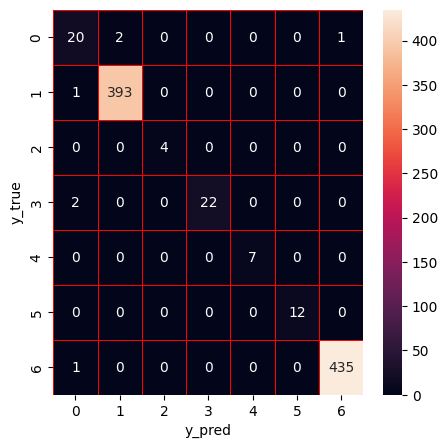

In [49]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [50]:
!pip install hyperopt

In [51]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:02<00:00,  8.12trial/s, best loss: -0.9955555555555555]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.9797694855585216, 'max_depth': 75.0, 'n_estimators': 50.0}


Accuracy of XGBoost: 0.9933333333333333
Precision of XGBoost: 0.9934750351617441
Recall of XGBoost: 0.9933333333333333
F1-score of XGBoost: 0.9933227653178058
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.92      0.96        24
         4.0       0.88      1.00      0.93         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.96      0.97      0.97       900
weighted avg       0.99      0.99      0.99       900



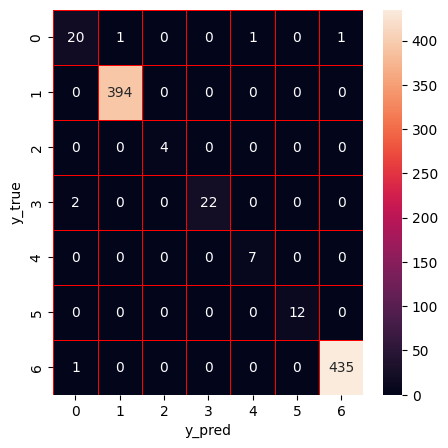

In [52]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [53]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9933333333333333
Precision of RF: 0.9935154381387258
Recall of RF: 0.9933333333333333
F1-score of RF: 0.9933452710162168
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.96      0.96      0.96        24
         4.0       0.75      0.86      0.80         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.99      0.99      0.99       900



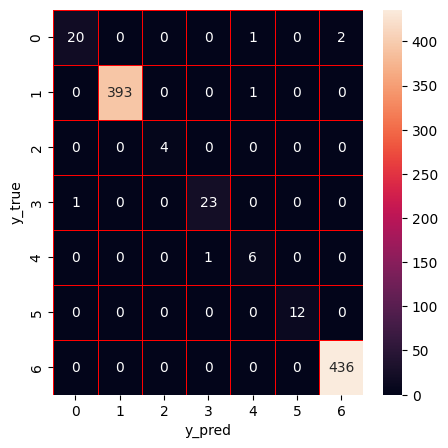

In [54]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [55]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47trial/s, best loss: -0.9955555555555555]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 28.0, 'max_features': 13.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 18.0}


Accuracy of RF: 0.9922222222222222
Precision of RF: 0.9928606935848314
Recall of RF: 0.9922222222222222
F1-score of RF: 0.9924555766962057
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86        23
         1.0       1.00      0.99      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.96      0.96      0.96        24
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.98      0.97       900
weighted avg       0.99      0.99      0.99       900



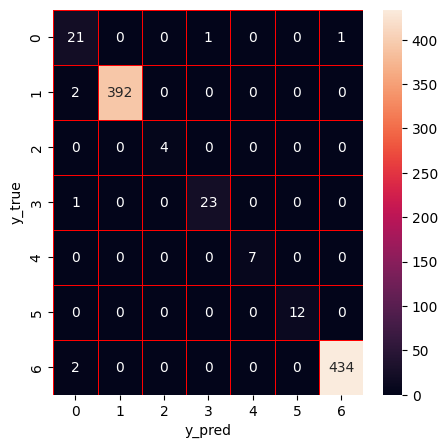

In [56]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [57]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9922222222222222
Precision of DT: 0.9924051000192282
Recall of DT: 0.9922222222222222
F1-score of DT: 0.9923005601083538
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.96      0.96      0.96        24
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      0.99      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.99      0.99      0.99       900



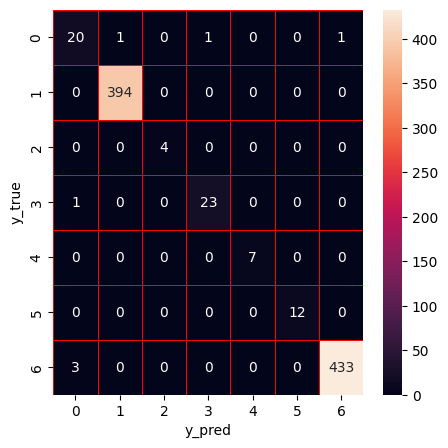

In [58]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [59]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 56.90trial/s, best loss: -0.9933333333333333]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 14.0, 'max_features': 16.0, 'min_samples_leaf': 7.0, 'min_samples_split': 10.0}


Accuracy of DT: 0.99
Precision of DT: 0.9907612831867941
Recall of DT: 0.99
F1-score of DT: 0.9902988961454294
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82        23
         1.0       1.00      0.99      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.96      0.96      0.96        24
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      0.99      1.00       436

    accuracy                           0.99       900
   macro avg       0.96      0.97      0.97       900
weighted avg       0.99      0.99      0.99       900



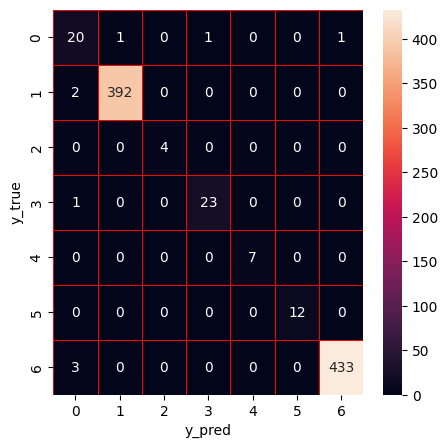

In [60]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [61]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9977777777777778
Precision of ET: 0.9979192092550215
Recall of ET: 0.9977777777777778
F1-score of ET: 0.9977649461395165
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00        24
         4.0       0.88      1.00      0.93         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.99      0.98       900
weighted avg       1.00      1.00      1.00       900



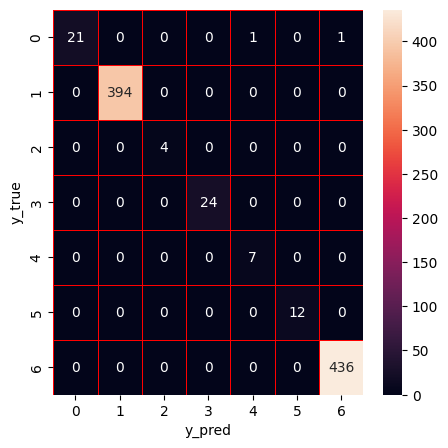

In [62]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [63]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79trial/s, best loss: -0.9755555555555555]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 35.0, 'max_features': 11.0, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 119.0}


Accuracy of ET: 0.9966666666666667
Precision of ET: 0.9967575930934054
Recall of ET: 0.9966666666666667
F1-score of ET: 0.9966554827109043
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.88      1.00      0.93         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.98      0.98       900
weighted avg       1.00      1.00      1.00       900



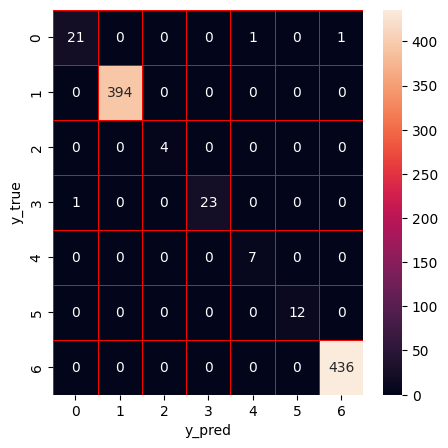

In [64]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [65]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [66]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1.0,1.0,1.0,1
1,6.0,6.0,6.0,6
2,1.0,1.0,1.0,1
3,6.0,6.0,6.0,6
4,1.0,1.0,1.0,1


In [67]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [68]:
dt_train.shape

(5549, 1)

In [69]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9911111111111112
Precision of Stacking: 0.9928610412884606
Recall of Stacking: 0.9911111111111112
F1-score of Stacking: 0.9916442837839138
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89        23
         1.0       1.00      0.99      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.64      1.00      0.78         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      0.99      1.00       436

    accuracy                           0.99       900
   macro avg       0.93      0.98      0.95       900
weighted avg       0.99      0.99      0.99       900



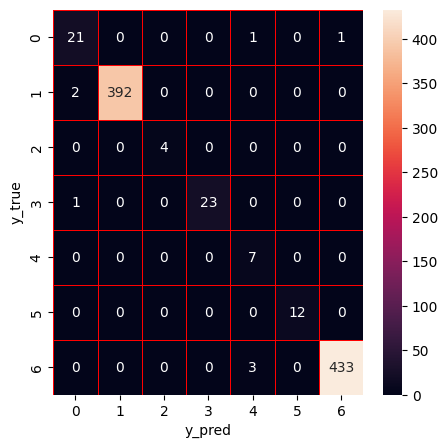

In [70]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [71]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:00<00:00, 23.99trial/s, best loss: -0.9933333333333333]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.4023481535762679, 'max_depth': 4.0, 'n_estimators': 10.0}


Accuracy of XGBoost: 0.9933333333333333
Precision of XGBoost: 0.9948938695712889
Recall of XGBoost: 0.9933333333333333
F1-score of XGBoost: 0.9937731945689883
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        23
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.64      1.00      0.78         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      0.99      1.00       436

    accuracy                           0.99       900
   macro avg       0.94      0.98      0.96       900
weighted avg       0.99      0.99      0.99       900



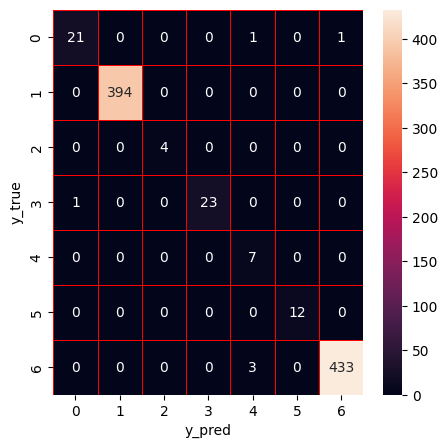

In [72]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [73]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [74]:
df.Label.value_counts()

Label
6    2180
1    1966
3     121
0     114
5      57
4      36
2      22
Name: count, dtype: int64

In [75]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [76]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [77]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [78]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [79]:
df1.Label.value_counts()

Label
1    4325
0     114
Name: count, dtype: int64

In [80]:
df2.Label.value_counts()

Label
1    57
Name: count, dtype: int64

In [81]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [82]:
df2.Label.value_counts()

Label
1    57
0     8
Name: count, dtype: int64

## ------ FIXED CODE BELOW 4371, This error occurs because the append method has been removed from pandas starting with version 2.0.0. The recommended approach is to use pandas.concat() instead.------

In [83]:
df = pd.concat([df1, df2], ignore_index=True)

In [84]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4382
0     122
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [85]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [86]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [87]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [88]:
X_fs = df[fs].values

In [89]:
X_fs.shape

(4504, 42)

In [90]:
X_fs

array([[-0.06324533, -1.23405213, -0.06324533, ..., -0.08123959,
        -0.04953189, -0.01918501],
       [-0.06685342, -1.25391376, -0.06685342, ..., -0.08123959,
        -0.05605396, -0.06324473],
       [-0.06748781, -0.60817417, -0.06748781, ..., -0.08118403,
        -0.04953189, -0.05417361],
       ...,
       [-0.05493217,  3.91137247, -0.05493217, ..., -0.08123843,
        -0.0234436 ,  0.02228296],
       [-0.06783144, -1.23381568, -0.06783144, ..., -0.08111459,
        -0.06257603, -0.08397872],
       [-0.0639458 ,  1.04759263, -0.0639458 , ..., -0.08113774,
        -0.05605396,  0.06375094]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [91]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [92]:
X_fss = fcbf.fit_transform(X_fs,y)

In [93]:
X_fss.shape

(4504, 20)

In [94]:
X_fss

array([[-1.63806716, -0.31282261, -0.31209574, ...,  6.1447954 ,
         6.1447954 ,  0.66523787],
       [-1.6180822 ,  6.94511261,  6.94743407, ...,  0.09857432,
         0.09857432, -0.13717256],
       [-1.61142055, -0.31282261, -0.31209574, ...,  9.34103198,
         9.34103198,  0.66608274],
       ...,
       [-1.43155587, -0.31282261, -0.31209574, ...,  2.21499902,
         2.21499902,  0.37045043],
       [-0.55887912, -0.31282261, -0.31209574, ..., -0.22789194,
        -0.22789194, -0.15111283],
       [ 1.1531661 , -0.31282261, -0.31209574, ..., -0.13744242,
        -0.13744242, -0.12407715]])

####  kernel principal component analysis (KPCA)

In [95]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [96]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [97]:
pd.Series(y_train).value_counts()

1    4325
0     114
Name: count, dtype: int64

In [98]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [99]:
pd.Series(y_train).value_counts()

1    18225
0      114
Name: count, dtype: int64

In [100]:
pd.Series(y_test).value_counts()

1    57
0     8
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [101]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [102]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [103]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        57

    accuracy                           0.88        65
   macro avg       0.44      0.50      0.47        65
weighted avg       0.77      0.88      0.82        65

0.8769230769230769
[[ 0  8]
 [ 0 57]]


### Hyperparameter optimization of CL-k-means
Tune "k"

## ----- ADDED LINE BELOW 4371  Python is unable to find the skopt module because it hasn't been installed yet. -----

In [104]:
!pip install numpy
!pip install --upgrade scikit-optimize

In [105]:
import skopt
import numpy as np
np.int = int
print(f"scikit-optimize version: {skopt.__version__}")
print(f"NumPy version: {np.__version__}")

scikit-optimize version: 0.10.2
NumPy version: 1.26.4


In [106]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans # 4371 ADDED TO FIX ERROR OF minibatchkmeans NOT BEING IMPORTED

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
try:
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    print("Best score=%.4f" % (1 - res_gp.fun))
    print("Best parameters: n_clusters=%d" % res_gp.x[0])
except Exception as e:
    print(f"An error occurred: {e}")
t2 = time.time()
print(t2 - t1)

30 0.8769230769230769
43 0.8769230769230769
43 0.8769230769230769
43 0.8769230769230769
32 0.8769230769230769
20 0.8769230769230769
16 0.8769230769230769
5 0.46153846153846156
15 0.8769230769230769
25 0.8769230769230769
50 0.8769230769230769
38 0.8769230769230769
47 0.8769230769230769
35 0.8769230769230769
22 0.8769230769230769
41 0.9076923076923077
40 0.8769230769230769
18 0.8769230769230769
27 0.8769230769230769
33 0.8769230769230769
Best score=0.9077
Best parameters: n_clusters=41
5.325726509094238


In [107]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

38 0.9230769230769231                                                                                                  
41 0.8769230769230769                                                                                                  
42 0.8769230769230769                                                                                                  
10 0.8769230769230769                                                                                                  
6 0.8769230769230769                                                                                                   
8 0.8769230769230769                                                                                                   
23 0.8769230769230769                                                                                                  
22 0.8769230769230769                                                                                                  
13 0.8769230769230769                   

In [108]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        57

    accuracy                           0.88        65
   macro avg       0.44      0.50      0.47        65
weighted avg       0.77      0.88      0.82        65

0.8769230769230769
[[ 0  8]
 [ 0 57]]


### Apply the CL-k-means model with biased classifiers

In [110]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.